In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# Generate synthetic data for the example
def make_data(n_samples = 30000, t_max = 2.5):
    u0 = np.random.uniform(0.1, 2.0, size = (n_samples, 1)) # Initial condition
    k = np.random.uniform(0.3, 1.5, size = (n_samples, 1)) # Decay rate
    t  = np.random.uniform(0.0, t_max, size=(n_samples, 1)) # Time points
    u  = u0 * np.exp(-k * t) # Analytical solution of the ODE
    X = np.hstack([u0, k, t]).astype(np.float32) # Building traing inputs
    y = u.astype(np.float32)                        # Building training outputs
    return X, y

In [6]:
# Creating the dataset
n_samples = 30000
proportion = (5 / 6)
X, y = make_data(n_samples)

# Split data into training and validation sets
X_train, y_train = X[:int(proportion * n_samples)], y[:int(proportion * n_samples)]
X_val, y_val = X[int(proportion * n_samples):], y[int(proportion * n_samples):]

In [8]:
# Define the neural network model
model = models.Sequential([
    layers.Input(shape=(3,)), # Input layer for (u0, k, t)
    layers.Dense(64, activation='tanh'), # choosing tanh activation function because it works well for smooth and continuous functions like exponentials 
    layers.Dense(64, activation='tanh'),
    layers.Dense(1)
])

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 64)             │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,481 (17.50 KB)

 Trainable params: 4,481 (17.50 KB)

 Non-trainable params: 0 (0.00 B)

In [9]:
# Compile the model
model.compile(optimizer=optimizers.Adam(learning_rate=0.001), loss='mse') # Mean Squared Error loss with Adam optimizer

In [10]:
# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=30,
    batch_size=512,
    verbose=2 # Show training progress per epoch by a single line
)

Epoch 1/30
49/49 - 1s - 20ms/step - loss: 0.0808 - val_loss: 0.0262
Epoch 2/30
49/49 - 0s - 2ms/step - loss: 0.0192 - val_loss: 0.0151
Epoch 3/30
49/49 - 0s - 3ms/step - loss: 0.0128 - val_loss: 0.0105
Epoch 4/30
49/49 - 0s - 2ms/step - loss: 0.0090 - val_loss: 0.0073
Epoch 5/30
49/49 - 0s - 2ms/step - loss: 0.0065 - val_loss: 0.0055
Epoch 6/30
49/49 - 0s - 2ms/step - loss: 0.0051 - val_loss: 0.0046
Epoch 7/30
49/49 - 0s - 2ms/step - loss: 0.0042 - val_loss: 0.0037
Epoch 8/30
49/49 - 0s - 2ms/step - loss: 0.0035 - val_loss: 0.0032
Epoch 9/30
49/49 - 0s - 2ms/step - loss: 0.0030 - val_loss: 0.0027
Epoch 10/30
49/49 - 0s - 2ms/step - loss: 0.0026 - val_loss: 0.0023
Epoch 11/30
49/49 - 0s - 2ms/step - loss: 0.0023 - val_loss: 0.0021
Epoch 12/30
49/49 - 0s - 3ms/step - loss: 0.0021 - val_loss: 0.0019
Epoch 13/30
49/49 - 0s - 2ms/step - loss: 0.0018 - val_loss: 0.0017
Epoch 14/30
49/49 - 0s - 2ms/step - loss: 0.0017 - val_loss: 0.0016
Epoch 15/30
49/49 - 0s - 3ms/step - loss: 0.0016 - val_l

In [11]:
# Test the model on new data with new initial conditions and decay rates so that the model is not tested on just the training decay curve but rather tests for rule behind it
u0_test = 1.5 
k_test = 0.7
t_grid = np.linspace(0, 2.5, 51).reshape(-1, 1).astype(np.float32)
X_test = np.hstack([
    np.full_like(t_grid, u0_test),
                     np.full_like(t_grid, k_test),
                     t_grid
])
u_pred  = model.predict(X_test)
u_true  = u0_test * np.exp(-k_test * t_grid)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


In [12]:
# Evaluate the model
mse = np.mean((u_true - u_pred) ** 2)
re_L2 = np.linalg.norm(u_true - u_pred) / np.linalg.norm(u_true)
print(f"Test MSE: {mse:.6e}, Relative L2 Error: {re_L2:.6e}")

Test MSE: 7.122408e-04, Relative L2 Error: 3.351214e-02


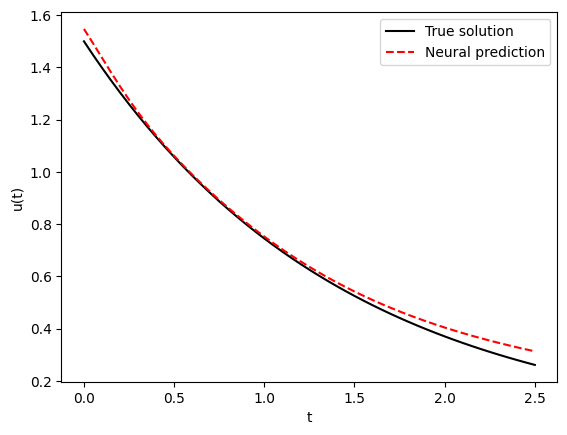

In [14]:
# Plot training history
plt.plot(t_grid, u_true, 'k-', label='True solution')
plt.plot(t_grid, u_pred, 'r--', label='Neural prediction')
plt.xlabel("t")
plt.ylabel("u(t)")
plt.legend()
plt.show()